In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.io import loadmat
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering
from skimage.measure import compare_ssim
from scipy.spatial.distance import cosine
%matplotlib inline
import cPickle
from eegtools.io import load_edf

In [2]:
data = loadmat('../ICA_channelsFull.mat')['arr']
print len(data), len(data[0])

61 1807250


In [3]:
length_of_intervals = 30000
channels = 61
edges = 61*61
total_interval = len(data[0])/length_of_intervals + 1
channels_data = [[None for j in range(edges)] for i in range(total_interval)] 

In [4]:
zer = []
pos_nine = []
abs_nine = []
def calculate_pearson(interval):
    index_counter = 0
    zeroes = 0
    pnine = 0
    anine = 0
    x = length_of_intervals * interval
    y = x + length_of_intervals
    for start in range(channels):
        for index in range(channels):
            if interval != total_interval:
                if (pearsonr(data[start][x:y], data[index][x:y])[1] >= 0.05):
                    channels_data[interval][index_counter] = 0
                    zeroes += 1
                else:
                    channels_data[interval][index_counter] = pearsonr(data[start][x:y], data[index][x:y])[0]
                if (pearsonr(data[start][x:y], data[index][x:y])[0] >= 0.9):
                    pnine += 1
                if (abs(pearsonr(data[start][x:y], data[index][x:y])[0]) >= 0.9):
                    anine += 1
                
            else:
                if (pearsonr(data[start][x:], data[index][x:])[1] >= 0.05):
                    channels_data[interval][index_counter] = 0
                    zeroes += 1
                else:
                    channels_data[interval][index_counter] = pearsonr(data[start][x:], data[index][x:])[0]
                if (pearsonr(data[start][x:y], data[index][x:])[0] >= 0.9):
                    pnine += 1
                if (abs(pearsonr(data[start][x:y], data[index][x:])[0]) >= 0.9):
                    anine += 1    
                
            index_counter += 1
    zer.append(zeroes)
    pos_nine.append(pnine)
    abs_nine.append(anine)
    print index_counter, zeroes, pnine, anine

In [5]:
for i in range(total_interval):
    print 'Calculating Interval %s' % i,
    calculate_pearson(i)


Calculating Interval 0 3721 12 261 261
Calculating Interval 1 3721 6 331 331
Calculating Interval 2 3721 0 427 427
Calculating Interval 3 3721 0 335 335
Calculating Interval 4 3721 4 315 315
Calculating Interval 5 3721 2 287 287
Calculating Interval 6 3721 24 293 293
Calculating Interval 7 3721 0 565 565
Calculating Interval 8 3721 4 305 305
Calculating Interval 9 3721 14 309 309
Calculating Interval 10 3721 8 293 293
Calculating Interval 11 3721 14 365 365
Calculating Interval 12 3721 2 379 379
Calculating Interval 13 3721 6 263 263
Calculating Interval 14 3721 0 305 305
Calculating Interval 15 3721 20 325 325
Calculating Interval 16 3721 6 383 383
Calculating Interval 17 3721 24 331 331
Calculating Interval 18 3721 20 315 315
Calculating Interval 19 3721 26 315 315
Calculating Interval 20 3721 2 207 207
Calculating Interval 21 3721 2 337 337
Calculating Interval 22 3721 8 313 313
Calculating Interval 23 3721 26 309 309
Calculating Interval 24 3721 30 345 345
Calculating Interval 25 3

In [8]:
print sum(zer)
print sum(pos_nine)
print sum(abs_nine)

822
21029
21029


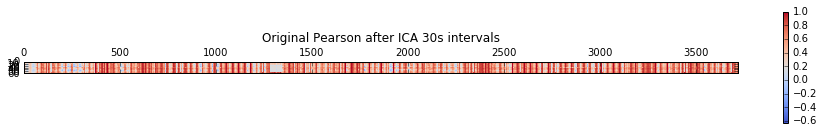

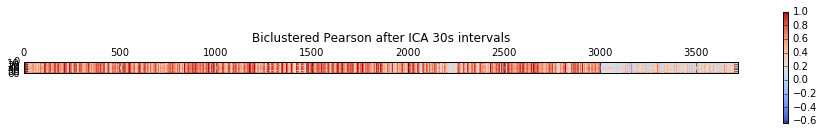

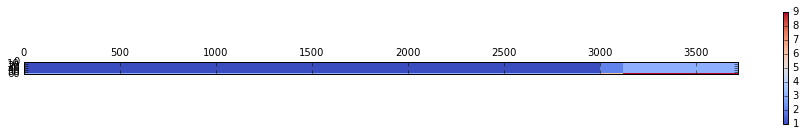

In [9]:
post_process_data = np.array(channels_data)
spectral_model = SpectralCoclustering(3)
spectral_model.fit(post_process_data)
fit_data = post_process_data[np.argsort(spectral_model.row_labels_)]
fit_data = fit_data[:, np.argsort(spectral_model.column_labels_)]
plt.matshow(post_process_data, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Original Pearson after ICA 30s intervals\n')
# plt.savefig('../media/json/pearson/ICA/pearson_ICA_30s.png')
plt.matshow(fit_data, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Biclustered Pearson after ICA 30s intervals\n')
# plt.savefig('../media/json/pearson/ICA/pearson_ICA_30s.png')
plt.matshow(np.outer(np.sort(spectral_model.row_labels_) + 1,
                     np.sort(spectral_model.column_labels_) + 1),
            cmap=plt.cm.coolwarm)
plt.colorbar()

In [7]:
import json as simplejson
with open('../ICA_pearson2.json', 'w+') as f:
    p = [[float(column) for column in row] for row in channels_data]
    f.write(simplejson.dumps({'name': 's5d2nap', 'data': p}))
    
with open('../ICA_pearson2_clustered.json', 'w+') as f:
    p = [[float(column) for column in row] for row in fit_data]
    f.write(simplejson.dumps({'name': 's5d2nap', 'data': p}))

# cols = np.argsort(spectral_model.column_labels_)
# rows = np.argsort(spectral_model.row_labels_)
# indices_matrix = []   
# for row in rows:
#     for col in cols:
#         indices_matrix.append((float(row),float(col)))

# with open('../media/json/pearson/ICA/fitted-indices-ICA-pearson-30s.json', 'w+') as f:
#     f.write(simplejson.dumps({'name': 's5d2nap', 'data': indices_matrix}))

# # with open('C:\Users\Fioger\Desktop\eeg-viz\postprocess/pearson/z_score/z_score_pearson_30s_dump.dump', 'wb') as f:
# #     cPickle.dump(channels_data, f)